In [1]:
# Loading

import pandas as pd
df_combined = pd.read_parquet('parquets/house5/df_combined1') # Choose Paquet with dataframe

In [2]:
for col in df_combined.columns:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

In [3]:
# Choose devices for running in ml

device_columns = [ 'hairdryer', '24_inch_lcd_bedroom', 'kettle', 'oven', 'dishwasher', 'washer_dryer'] # house 5

# device_columns = ['kettle', 'rice_cooker', 'washing_machine', 'dish_washer', 'microwave', 'toaster'] # house 2

# Check unique states for each device
for device in device_columns:
    unique_states = df_combined[device].unique()
    print(f"Device: {device}, Unique States: {unique_states}, Number of States: {len(unique_states)}")

Device: hairdryer, Unique States: [0 2 1 3], Number of States: 4
Device: 24_inch_lcd_bedroom, Unique States: [0 1], Number of States: 2
Device: kettle, Unique States: [0 1], Number of States: 2
Device: oven, Unique States: [0 2 1 3], Number of States: 4
Device: dishwasher, Unique States: [0 1 4 2 3], Number of States: 5
Device: washer_dryer, Unique States: [1 3 0 2 4], Number of States: 5


<h3><center><b>Random forests</b></center></h3>
<hr>

In [5]:
df_combined.drop('timestamp', axis=1, inplace=True)

In [6]:
X = df_combined[['what_hour', 'what_day', 'is_weekend', 'aggregate', 'agg_clustered']]

Y_columns = df_combined.columns.difference(X.columns)
Y = df_combined[Y_columns]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
# here we search for the best parameters in random forest

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# for grid search
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

base_rf = RandomForestClassifier(random_state=42)
model = MultiOutputClassifier(base_rf, n_jobs=-1)

# GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, Y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

best_params = grid_search.best_params_

best_rf = RandomForestClassifier(
    n_estimators=best_params['estimator__n_estimators'],
    max_depth=best_params['estimator__max_depth'],
    min_samples_split=best_params['estimator__min_samples_split'],
    min_samples_leaf=best_params['estimator__min_samples_leaf'],
    random_state=42
)

best_model = MultiOutputClassifier(best_rf, n_jobs=-1)

# The best_model now looks like this:
print(best_model)


In [9]:
# Best parameters found

from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

best_rf = RandomForestClassifier(n_estimators= 50, min_samples_leaf= 1, min_samples_split= 2, max_depth= None, random_state=42)

model = MultiOutputClassifier(best_rf, n_jobs=1)

In [10]:
model.fit(X_train, Y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=50,
                                                       random_state=42),
                      n_jobs=1)

In [11]:
y_pred = model.predict(X_test)

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import hamming_loss

def exact_match_accuracy(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    exact_matches = np.all(true == pred, axis=1)
    accuracy = np.mean(exact_matches)
    return accuracy

y_pred_df = pd.DataFrame(y_pred, columns=Y_test.columns, index=Y_test.index)

Y_test_np = Y_test.to_numpy().astype(int)
y_pred_np = y_pred_df.to_numpy().astype(int)

# accuracy
exact_accuracy = exact_match_accuracy(Y_test_np, y_pred_np)
print(f"Exact Match Accuracy: {exact_accuracy:.2%}")

mismatches = Y_test_np != y_pred_np
hamming_losses = mismatches.mean(axis=0)
hamming_accuracies = 1 - hamming_losses

# Hamming accuracy for each label
for i, accuracy in enumerate(hamming_accuracies):
    print(f"Hamming Accuracy for Label {i+1} ({Y_test.columns[i]}): {accuracy:.2%}")

# overall Hamming accuracy
overall_hamming_accuracy = 1 - np.mean(hamming_losses)
print(f"Overall Hamming Accuracy: {overall_hamming_accuracy:.2%}")


Exact Match Accuracy: 98.67%
Hamming Accuracy for Label 1 (24_inch_lcd_bedroom): 99.38%
Hamming Accuracy for Label 2 (dishwasher): 99.63%
Hamming Accuracy for Label 3 (hairdryer): 99.99%
Hamming Accuracy for Label 4 (kettle): 99.95%
Hamming Accuracy for Label 5 (oven): 99.72%
Hamming Accuracy for Label 6 (washer_dryer): 99.57%
Overall Hamming Accuracy: 99.71%


In [13]:
from sklearn.metrics import classification_report

print("Classification Report for each target:")
for i, column in enumerate(Y_test.columns):
    print(f"\nClassification Report for {column}:")
    print(classification_report(Y_test.iloc[:, i], y_pred[:, i], zero_division=0))


Classification Report for each target:

Classification Report for 24_inch_lcd_bedroom:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57053
           1       0.92      0.91      0.91      2161

    accuracy                           0.99     59214
   macro avg       0.96      0.95      0.96     59214
weighted avg       0.99      0.99      0.99     59214


Classification Report for dishwasher:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57970
           1       0.61      0.49      0.55        67
           2       0.87      0.90      0.88       654
           4       0.98      0.98      0.98       523

    accuracy                           1.00     59214
   macro avg       0.86      0.84      0.85     59214
weighted avg       1.00      1.00      1.00     59214


Classification Report for hairdryer:
              precision    recall  f1-score   support

           0       

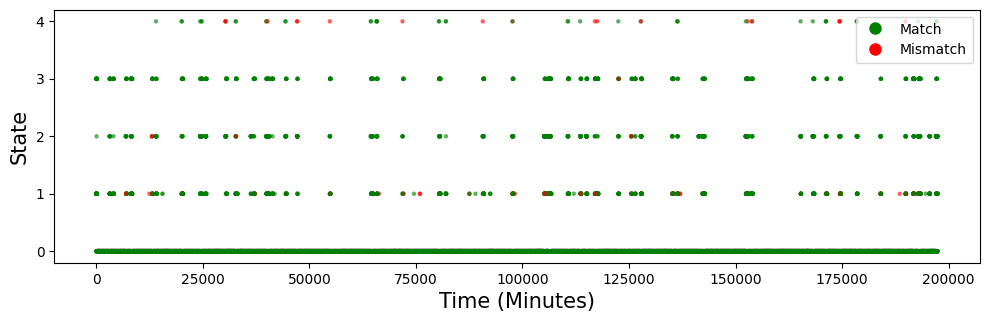

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

#  choose the device number for visualization
device = 5
n_samples =  49345

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
y_pred = pd.DataFrame(y_pred)

colors = np.array(['green' if int(a) == int(b) else 'red' for a, b in zip(y_pred.iloc[:n_samples, device], Y_test.iloc[:n_samples, device])])

x_indices = Y_test.index[:n_samples]

scatter = plt.scatter(x_indices, Y_test.iloc[:n_samples, device].astype(int),
                      c=colors, alpha=0.5, s=5)

plt.yticks(np.arange(min(Y_test.iloc[:n_samples, device].astype(int)), max(Y_test.iloc[:n_samples, device].astype(int)) + 1))

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Match',
                          markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Mismatch',
                          markerfacecolor='red', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')

plt.ylabel('State', fontsize=15)
plt.xlabel('Time (Minutes)', fontsize=15)

plt.tight_layout()
plt.show()

In [15]:
# Extract feature importance

for i, estimator in enumerate(model.estimators_):
    print(f"Feature importances for target {Y_train.columns[i]}:")
    importances = estimator.feature_importances_
    features = X_train.columns
    indices = importances.argsort()[::-1]

    for f in range(X_train.shape[1]):
        print(f"{features[indices[f]]}: {importances[indices[f]]}")
    print("\n")


Feature importances for target 24_inch_lcd_bedroom:
aggregate: 0.5418505499350287
what_hour: 0.22587796891992498
agg_clustered: 0.1700373348855909
what_day: 0.056257129575134374
is_weekend: 0.005977016684321148


Feature importances for target dishwasher:
aggregate: 0.5379602162178689
agg_clustered: 0.23168815088354708
what_hour: 0.15724395382808717
what_day: 0.06705881929215506
is_weekend: 0.006048859778341763


Feature importances for target hairdryer:
aggregate: 0.5726813013297102
what_hour: 0.27647584067231334
agg_clustered: 0.13776949645320868
what_day: 0.011171471016585137
is_weekend: 0.001901890528182748


Feature importances for target kettle:
aggregate: 0.4704252057877759
agg_clustered: 0.24675972446720026
what_hour: 0.1909406152478155
what_day: 0.0813334080381399
is_weekend: 0.010541046459068311


Feature importances for target oven:
aggregate: 0.5088448325059659
agg_clustered: 0.27868219230088853
what_hour: 0.1527689363730318
what_day: 0.05145555714596026
is_weekend: 0.00824